EDA — Readmission for Diabetes Patients (Group Project) 

Using cleaned dataset: `jupyter-nb-space/explanations-encodedDataset/output.csv`. 

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility + display
np.random.seed(641)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

# --- paths ---
REPO_ROOT = Path(".").resolve()
DATA_DIR  = REPO_ROOT / "explanations-encodedDataset"
FIG_DIR   = REPO_ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (7.5, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

print("Using data from:", DATA_DIR)

Using data from: C:\SchoolWork\COMP641\Projects\readmission-for-diabetes-patients\jupyter-nb-space\explanations-encodedDataset


In [2]:
# The EDA-ready file
clean_file = DATA_DIR / "output.csv"
assert clean_file.exists(), f"{clean_file} not found. Pull latest main."

df = pd.read_csv(clean_file, low_memory=False)
print("Shape:", df.shape)
df.head(3)

Shape: (101766, 49)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,1,2,0,6,25,1,1,0,1,41,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,1,2,1,1,1,7,3,0,0,59,0,18,0,0,0,2,1,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,2
2,64410,86047875,2,2,2,1,1,7,2,0,0,11,5,13,2,0,1,3,2,2,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [3]:
# Encodings (kept here so plots show human-readable labels)
race_map   = {0:"?", 1:"Caucasian", 2:"AfricanAmerican", 3:"Asian", 4:"Hispanic", 5:"Other"}
gender_map = {0:"Unknown/Invalid", 1:"Male", 2:"Female"}
age_map    = {0:"[0-10)",1:"[10-20)",2:"[20-30)",3:"[30-40)",4:"[40-50)",5:"[50-60)",
              6:"[60-70)",7:"[70-80)",8:"[80-90)",9:"[90-100)"}
# Target: 0=no, 1=<30, 2=>30
readmit_map = {0:"no", 1:"<30", 2:">30"}

# Labs
a1c_map = {0:"None", 1:"norm", 2:">7", 3:">8"}
glu_map = {0:"None", 1:"norm", 2:">200", 3:">300"}

# Insulin (0=no, 1=steady, 2=up, 3=down)
insulin_map = {0:"no", 1:"steady", 2:"up", 3:"down"}

# Convenient helper to map safely if the column exists
def map_labels(series, mapping):
    s = series.copy()
    try:
        s = s.astype("Int64")
    except Exception:
        pass
    return s.map(mapping).fillna(series)

# Convenience: name of target column
TARGET = "readmitted"

UNIVARIATE
1. Overall bar for 30-day readmissions (target distribution)

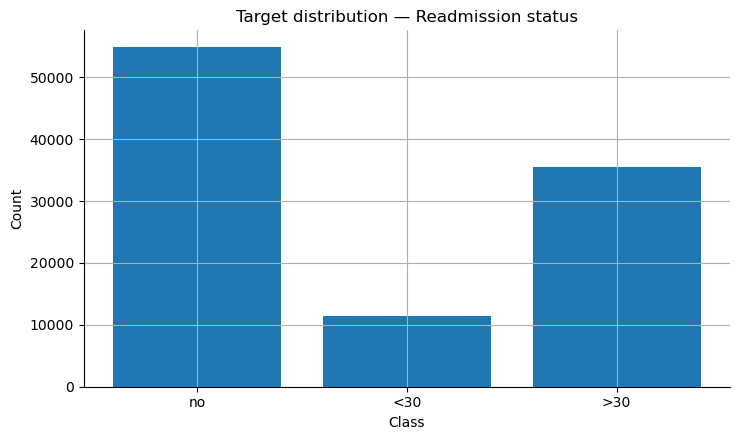

readmitted
0    53.91
1    11.16
2    34.93
Name: count, dtype: float64

In [4]:
counts = df[TARGET].value_counts().sort_index()
labels = [readmit_map.get(int(k), str(k)) for k in counts.index]

plt.figure()
plt.bar(labels, counts.values)
plt.title("Target distribution — Readmission status")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "target_distribution_readmitted.png", dpi=150)
plt.show()

# also percentages (for write-up)
(counts / counts.sum() * 100).round(2)

The outcome is imbalanced (one class is much smaller than the others): no is 53.91%, <30 is 11.16%, and >30 is 34.93%. Because <30 is the minority class (the small group we care about), plain accuracy can be misleading. 

We will use stratified splits (we keep the same class proportions in train and test) and evaluate with recall (of all true <30 cases, how many we correctly find) and precision (of the cases we predict as <30, how many are actually <30>). We will also track PR-AUC (the area under the precision–recall curve) which is a better summary than accuracy when classes are imbalanced. Finally, we will tune the decision threshold (the cutoff where a probability becomes a positive prediction) to hit a target recall for <30.

2. Race/Ethnicity — bar plot of 30-day readmission rate by race

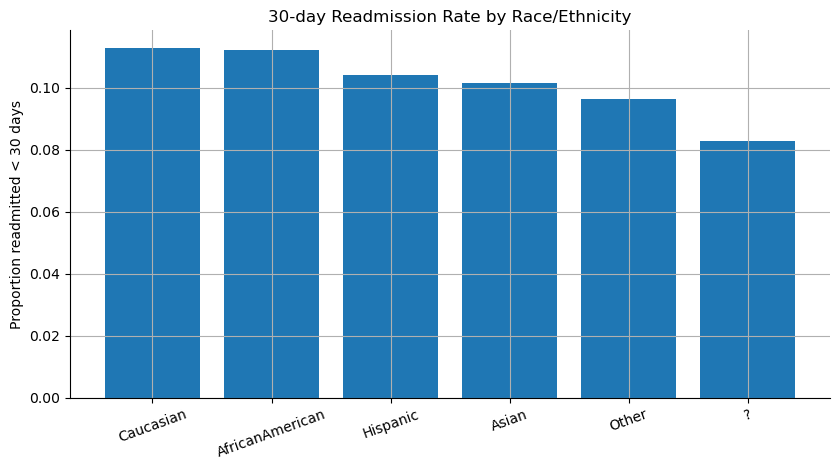

race
1    0.112906
2    0.112181
4    0.104075
3    0.101404
5    0.096282
0    0.082710
Name: readmitted, dtype: float64

In [5]:
col = "race"
tmp = df[[col, TARGET]].dropna()
rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean().sort_values(ascending=False)

x_labels = [race_map.get(int(k), str(k)) for k in rate.index]

plt.figure(figsize=(8.5, 4.8))
plt.bar(x_labels, rate.values)
plt.ylabel("Proportion readmitted < 30 days")
plt.title("30-day Readmission Rate by Race/Ethnicity")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(FIG_DIR / "rate_readmit_lt30_by_race.png", dpi=150)
plt.show()

rate

The <30 rates across racial groups are tightly clustered (Caucasian 11.29%, African American 11.22%, Hispanic 10.41%, Asian 10.14%, Other 9.63%, Unknown 8.27%) so differences are only a few percentage points (a percentage-point is the simple arithmetic difference between two percentages, e.g., 12% vs 10% = 2 points). This suggests a weak association (little relationship) between race and 30-day readmission in this dataset. 

We will still report fairness slices (metrics computed within each group) to confirm the model behaves similarly across groups, but we do not expect race by itself to add meaningful predictive lift (performance gain).

3. Age — distribution (counts)

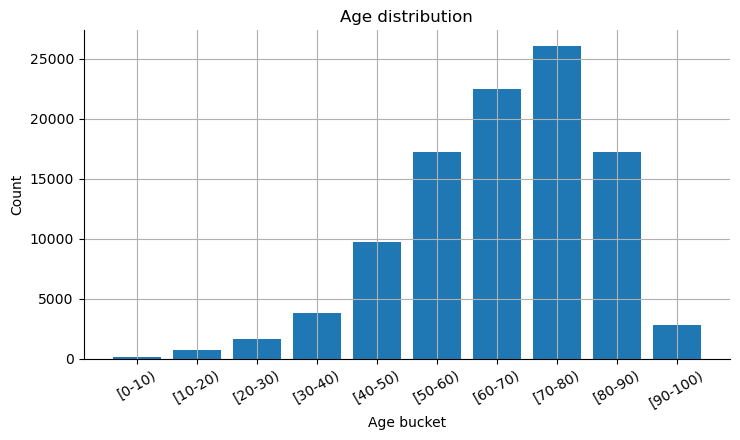

age
0      161
1      691
2     1657
3     3775
4     9685
5    17256
6    22483
7    26068
8    17197
9     2793
Name: count, dtype: int64

In [6]:
col = "age"
counts = df[col].value_counts().sort_index()
labels = [age_map.get(int(k), str(k)) for k in counts.index]

plt.figure()
plt.bar(labels, counts.values)
plt.title("Age distribution")
plt.xlabel("Age bucket")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(FIG_DIR / "age_distribution.png", dpi=150)
plt.show()

counts

Encounter counts skew older as the largest bucket is 70–80 (26,068), followed by 60–70 (22,483) and 50–60 (17,256), while younger buckets are smaller. Smaller groups give noisier estimates (more variability just due to few examples). 

We will stratify by age in our data splits so train and test have similar age mixes, and we will be cautious interpreting patterns in the youngest buckets.

4. Gender — distribution (counts) and <30 rate

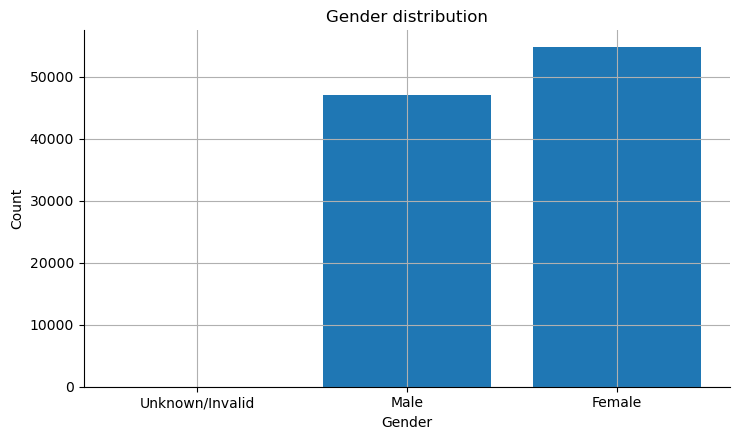

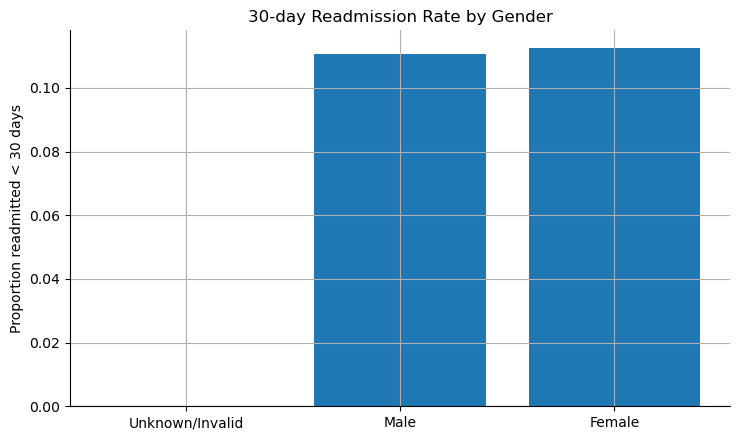

gender
0    0.000000
1    0.110615
2    0.112452
Name: readmitted, dtype: float64

In [7]:
col = "gender"
# counts
g_counts = df[col].value_counts().sort_index()
g_labels = [gender_map.get(int(k), str(k)) for k in g_counts.index]

plt.figure()
plt.bar(g_labels, g_counts.values)
plt.title("Gender distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "gender_distribution.png", dpi=150)
plt.show()

# <30 rate
tmp = df[[col, TARGET]].dropna()
rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean().reindex(g_counts.index)

plt.figure()
plt.bar(g_labels, rate.values)
plt.title("30-day Readmission Rate by Gender")
plt.ylabel("Proportion readmitted < 30 days")
plt.tight_layout()
plt.savefig(FIG_DIR / "rate_readmit_lt30_by_gender.png", dpi=150)
plt.show()

rate

Male and Female have nearly identical <30 rates—11.06% and 11.25%, respectively while the Unknown/Invalid group is tiny. That indicates minimal predictive signal (little ability to separate classes) from gender for this outcome. 

We will keep gender for completeness and for fairness slicing, but we do not expect it to materially improve performance.

BIVARIATE
1. Box plot — time_in_hospital vs readmission

C:\Users\phone\AppData\Local\Temp\ipykernel_29440\1195272437.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


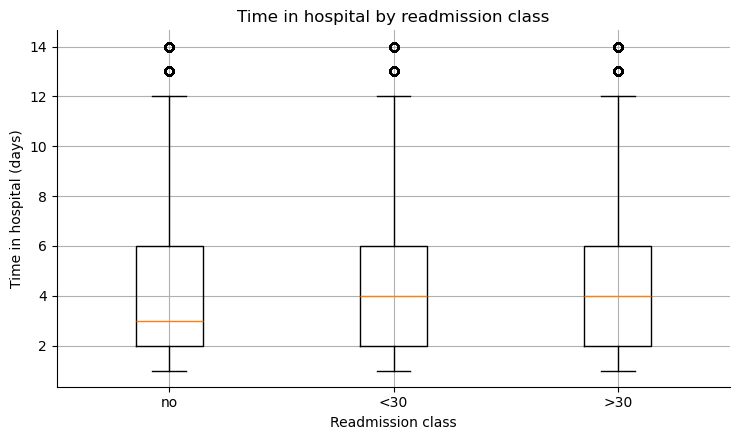

In [8]:
col = "time_in_hospital"
classes = sorted(df[TARGET].dropna().unique())
data = [df.loc[df[TARGET]==c, col].dropna().values for c in classes]
labels = [readmit_map.get(int(c), str(c)) for c in classes]

plt.figure()
plt.boxplot(data, labels=labels, showfliers=True)
plt.title("Time in hospital by readmission class")
plt.xlabel("Readmission class")
plt.ylabel("Time in hospital (days)")
plt.tight_layout()
plt.savefig(FIG_DIR / "box_time_in_hospital_by_readmit.png", dpi=150)
plt.show()

The length-of-stay distributions for no, <30, and >30 overlap substantially, with no clear median shift. Visually, that implies a small effect size (the difference between classes is small in practical terms). 

We will treat time_in_hospital as a context feature and expect it to be more useful in interactions (a feature becomes informative when combined with another, e.g., length of stay × prior visits) than as a standalone driver.

2. Relationship among number_outpatient, number_emergency, number_inpatient

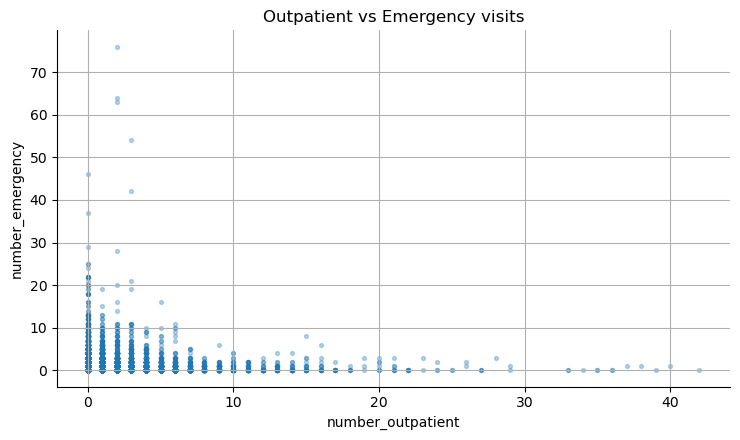

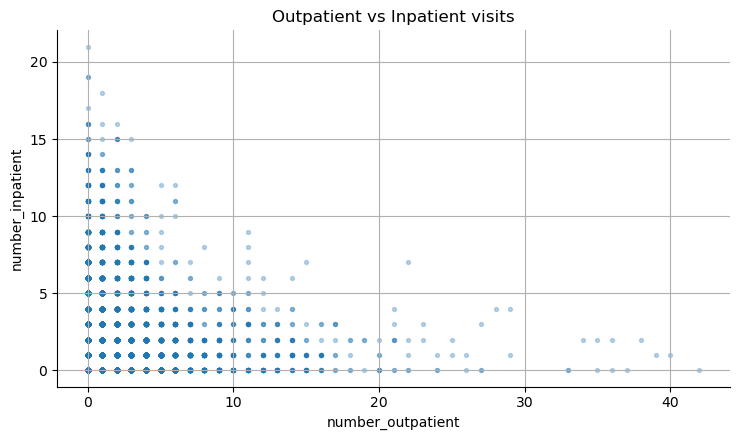

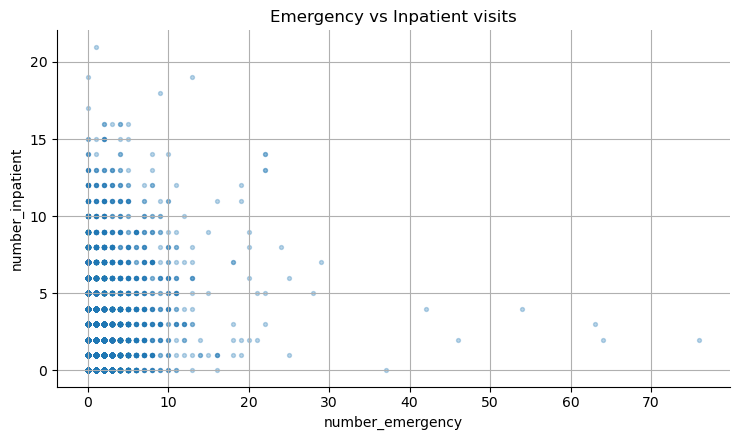

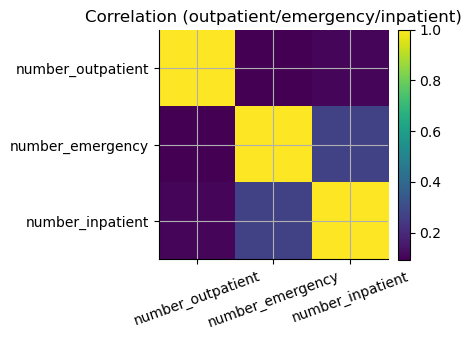

,number_outpatient,number_emergency,number_inpatient
number_outpatient,1.000000,0.091459,0.107338
number_emergency,0.091459,1.000000,0.266559
number_inpatient,0.107338,0.266559,1.000000


In [9]:
x1, x2, x3 = "number_outpatient", "number_emergency", "number_inpatient"

# Scatter: outpatient vs emergency
plt.figure()
plt.scatter(df[x1], df[x2], s=8, alpha=0.3)
plt.xlabel(x1); plt.ylabel(x2)
plt.title("Outpatient vs Emergency visits")
plt.tight_layout()
plt.savefig(FIG_DIR / "scatter_outpatient_vs_emergency.png", dpi=150)
plt.show()

# Scatter: outpatient vs inpatient
plt.figure()
plt.scatter(df[x1], df[x3], s=8, alpha=0.3)
plt.xlabel(x1); plt.ylabel(x3)
plt.title("Outpatient vs Inpatient visits")
plt.tight_layout()
plt.savefig(FIG_DIR / "scatter_outpatient_vs_inpatient.png", dpi=150)
plt.show()

# Scatter: emergency vs inpatient
plt.figure()
plt.scatter(df[x2], df[x3], s=8, alpha=0.3)
plt.xlabel(x2); plt.ylabel(x3)
plt.title("Emergency vs Inpatient visits")
plt.tight_layout()
plt.savefig(FIG_DIR / "scatter_emergency_vs_inpatient.png", dpi=150)
plt.show()

# Mini heatmap for correlations among the three
sub = df[[x1, x2, x3]].corr()
plt.figure(figsize=(4.5, 4))
im = plt.imshow(sub.values, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(3), sub.columns, rotation=20)
plt.yticks(range(3), sub.index)
plt.title("Correlation (outpatient/emergency/inpatient)")
plt.tight_layout()
plt.savefig(FIG_DIR / "corr_three_counts.png", dpi=150)
plt.show()

sub

All three visit counts are zero-inflated (many zeros) with a right tail (a few very large values). Correlations are low to moderate as emergency with inpatient is about 0.27 (the strongest of the three), outpatient with inpatient about 0.11, and outpatient with emergency about 0.09. A correlation is a number between –1 and 1 that measures linear association. Values near 0 indicate weak linear relationships. Because none of these are high, the features are not redundant (each adds different information). 

For modeling, we may apply a log(1+x) transform (compresses large values so extreme cases don’t dominate) or cap (winsorize), meaning we replace values above a chosen cutoff with the cutoff instead of deleting rows, to reduce the influence of outliers.

3. A1C result vs readmission rate (highlight >8)

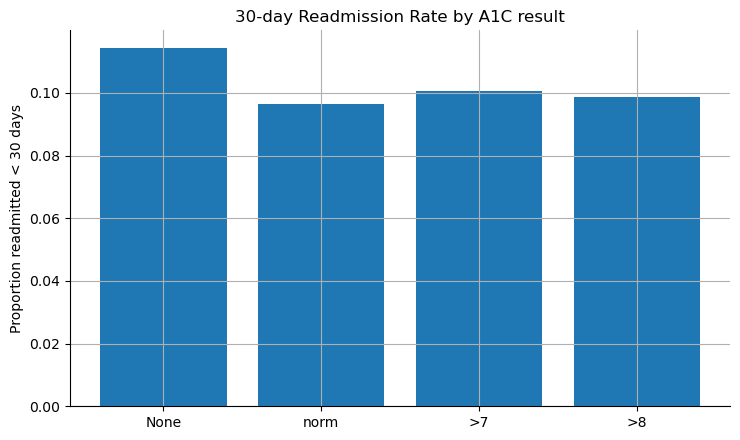

A1Cresult
0    0.114233
1    0.096593
2    0.100472
3    0.098710
Name: readmitted, dtype: float64

In [10]:
col = "A1Cresult"
tmp = df[[col, TARGET]].dropna()
rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean()

# order by the encoded meaning: 0=None, 1=norm, 2=>7, 3=>8
order = [0, 1, 2, 3]
rate = rate.reindex(order)
labels = [a1c_map.get(k, str(k)) for k in rate.index]

plt.figure()
bars = plt.bar(labels, rate.values)
plt.title("30-day Readmission Rate by A1C result")
plt.ylabel("Proportion readmitted < 30 days")
plt.tight_layout()
plt.savefig(FIG_DIR / "rate_readmit_lt30_by_A1C.png", dpi=150)
plt.show()

rate

The <30 rates by A1C are None 11.42%, norm 9.66%, >7 10.05%, >8 9.87%. “None” (no A1C recorded) is worse than “norm,” and >7 is similar to >8. This is informative missingness (the fact that a value is missing carries information about risk) so we will add a missing indicator (a 0/1 flag that A1C is missing) and we will not merge “None” with “normal.”

4. Insulin usage vs readmission rate

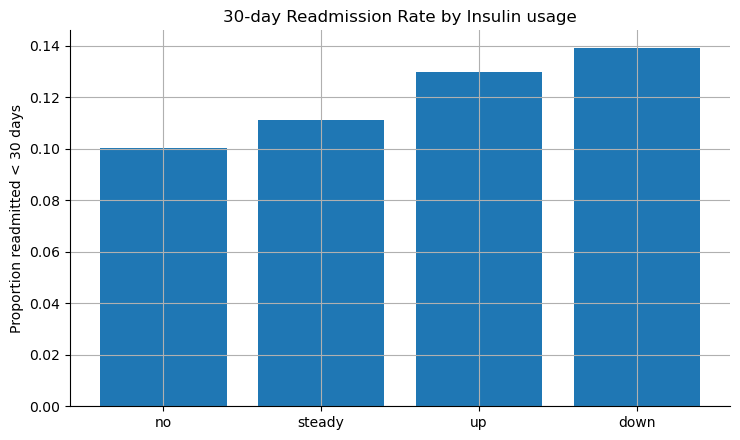

insulin
0    0.100374
1    0.111284
2    0.129905
3    0.138975
Name: readmitted, dtype: float64

In [11]:
col = "insulin"
tmp = df[[col, TARGET]].dropna()
rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean()

# Show in logical order: no, steady, up, down
order = [0, 1, 2, 3]
rate = rate.reindex(order)
labels = [insulin_map.get(k, str(k)) for k in rate.index]

plt.figure()
plt.bar(labels, rate.values)
plt.title("30-day Readmission Rate by Insulin usage")
plt.ylabel("Proportion readmitted < 30 days")
plt.tight_layout()
plt.savefig(FIG_DIR / "rate_readmit_lt30_by_insulin.png", dpi=150)
plt.show()

rate

There is a clear gradient (ordered pattern) like no 10.04% < steady 11.13% < up 12.99% ≈ down 13.90%. Changes in insulin (up or down) likely reflect clinical instability or disease severity, which tracks with higher <30. Insulin status is therefore a strong clinical signal. 

Alongside the four-level variable, we will create a simple derived flag insulin_changed that is 1 if the state is up or down, else 0.

Summary tables

In [12]:
ARTIFACTS = REPO_ROOT / "processed"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Target distribution
target_counts = df[TARGET].value_counts().sort_index()
target_pct = (target_counts/target_counts.sum()*100).round(2)
pd.DataFrame({"count": target_counts, "pct": target_pct}).to_csv(ARTIFACTS / "target_distribution.csv")

# A1C vs <30
(pd.DataFrame({"rate_lt30": (df[TARGET]==1).groupby(df["A1Cresult"]).mean()})
 .reindex([0,1,2,3])
 .to_csv(ARTIFACTS / "a1c_vs_lt30.csv"))

# Insulin vs <30
(pd.DataFrame({"rate_lt30": (df[TARGET]==1).groupby(df["insulin"]).mean()})
 .reindex([0,1,2,3])
 .to_csv(ARTIFACTS / "insulin_vs_lt30.csv"))